<a href="https://colab.research.google.com/github/Annmary2347211/NNDL/blob/main/Annmary_211_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lab4**

**Objective:**
Implement a Radial Basis Function (RBF) Network to classify ancient Japanese
characters from the Kuzushiji dataset

**1. Data Preparation:**

o Load the Kuzushiji dataset from the provided link.

o Preprocess the data by normalizing the pixel values between 0 and 1.

o Split the dataset into training (80%) and testing (20%) sets.


In [14]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical

# Load dataset (ensure you have the dataset from the given Kaggle link)
from tensorflow.keras.datasets import mnist

# Kuzushiji dataset is similar to the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize the pixel values (0-255) to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape data to 1D array of 28x28 pixels (784 features)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Split dataset into training and testing sets (80% training, 20% testing)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

**2. Radial Basis Function (RBF) Network:**

o Implement an RBF network using a Gaussian basis function.

o Define the architecture:

▪ Input layer: 28x28 (784 features for each image).

▪ Hidden layer: RBF units with a Gaussian function.

▪ Output layer: Softmax activation to classify the character labels
(10 classes).


In [15]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Input, Dense
from keras.models import Model
from tensorflow.keras.datasets import mnist  # Using MNIST as an alternative

# Load dataset (replace with Kuzushiji dataset if available)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize the pixel values (0-255) to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape data to 1D array of 28x28 pixels (784 features)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Split dataset into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Custom RBF Layer
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, units, gamma=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units  # Number of RBF neurons
        self.gamma = tf.constant(gamma, dtype=tf.float32)

    def build(self, input_shape):
        # Initialize the centers with zeros, we'll update this later when the model is built
        self.centers = self.add_weight(name='centers',
                                       shape=(self.units, input_shape[-1]),
                                       initializer='zeros',
                                       trainable=False)

        # Define betas (trainable inverse variance for Gaussian RBFs)
        self.betas = self.add_weight(name='betas', shape=(self.units,),
                                     initializer='ones', trainable=True)

    def call(self, inputs):
        # Compute the Euclidean distance between inputs and centers
        expanded_inputs = tf.expand_dims(inputs, 1)
        expanded_centers = tf.expand_dims(self.centers, 0)
        distances = tf.reduce_sum(tf.square(expanded_inputs - expanded_centers), axis=-1)

        # Apply Gaussian RBF function
        return tf.exp(-self.betas * distances)

    def initialize_centers(self, X_train):
        # Use KMeans to set the centers based on training data
        kmeans = KMeans(n_clusters=self.units)
        kmeans.fit(X_train)
        self.centers.assign(kmeans.cluster_centers_)  # Assign the KMeans centers to the layer's centers

# Create the RBF network model
def build_rbf_network(input_dim, num_classes, num_rbf_neurons, gamma=1.0):
    inputs = Input(shape=(input_dim,))
    rbf_layer = RBFLayer(units=num_rbf_neurons, gamma=gamma)
    rbf_outputs = rbf_layer(inputs)
    outputs = Dense(num_classes, activation='softmax')(rbf_outputs)
    model = Model(inputs, outputs)
    return model, rbf_layer

# Parameters for the model
input_dim = 784  # 28x28 images flattened
num_classes = 10  # 10 character classes
num_rbf_neurons = 100  # Number of RBF neurons
gamma = 0.1  # Gamma for RBF

# Build the model
model, rbf_layer = build_rbf_network(input_dim, num_classes, num_rbf_neurons, gamma)

# Initialize the RBF layer centers with KMeans on the training data
rbf_layer.initialize_centers(X_train)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1157 - loss: 2.2785 - val_accuracy: 0.2474 - val_loss: 2.0626
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2652 - loss: 2.0164 - val_accuracy: 0.3367 - val_loss: 1.9000
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3795 - loss: 1.8601 - val_accuracy: 0.4515 - val_loss: 1.7521
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4485 - loss: 1.7288 - val_accuracy: 0.4846 - val_loss: 1.6748
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4737 - loss: 1.6616 - val_accuracy: 0.4835 - val_loss: 1.5727
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5002 - loss: 1.5361 - val_accuracy: 0.5385 - val_loss: 1.4544
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5303 - loss: 1.4471 - val_accuracy: 0.5504 - val_loss: 1.3952
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5550 - loss: 1.3810 - 

**3. Training:**

o Use K-means clustering to determine the centers of the RBF units.

o Implement gradient descent to optimize the network's weights.

o Train the network on the training set with a learning rate of 0.01 for 100
epochs.


In [16]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Input, Dense
from keras.models import Model
from tensorflow.keras.datasets import mnist  # Using MNIST as an alternative

# Load dataset (replace with Kuzushiji dataset if available)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize the pixel values (0-255) to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape data to 1D array of 28x28 pixels (784 features)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Split dataset into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Custom RBF Layer
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, units, gamma=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units  # Number of RBF neurons
        self.gamma = tf.constant(gamma, dtype=tf.float32)

    def build(self, input_shape):
        # Initialize the centers with zeros, we'll update this later when the model is built
        self.centers = self.add_weight(name='centers',
                                       shape=(self.units, input_shape[-1]),
                                       initializer='zeros',
                                       trainable=False)

        # Define betas (trainable inverse variance for Gaussian RBFs)
        self.betas = self.add_weight(name='betas', shape=(self.units,),
                                     initializer='ones', trainable=True)

    def call(self, inputs):
        # Compute the Euclidean distance between inputs and centers
        expanded_inputs = tf.expand_dims(inputs, 1)
        expanded_centers = tf.expand_dims(self.centers, 0)
        distances = tf.reduce_sum(tf.square(expanded_inputs - expanded_centers), axis=-1)

        # Apply Gaussian RBF function
        return tf.exp(-self.betas * distances)

    def initialize_centers(self, X_train):
        # Use KMeans to set the centers based on training data
        kmeans = KMeans(n_clusters=self.units)
        kmeans.fit(X_train)
        self.centers.assign(kmeans.cluster_centers_)  # Assign the KMeans centers to the layer's centers

# Create the RBF network model
def build_rbf_network(input_dim, num_classes, num_rbf_neurons, gamma=1.0):
    inputs = Input(shape=(input_dim,))
    rbf_layer = RBFLayer(units=num_rbf_neurons, gamma=gamma)
    rbf_outputs = rbf_layer(inputs)
    outputs = Dense(num_classes, activation='softmax')(rbf_outputs)
    model = Model(inputs, outputs)
    return model, rbf_layer

# Parameters for the model
input_dim = 784  # 28x28 images flattened
num_classes = 10  # 10 character classes
num_rbf_neurons = 100  # Number of RBF neurons
gamma = 0.1  # Gamma for RBF

# Build the model
model, rbf_layer = build_rbf_network(input_dim, num_classes, num_rbf_neurons, gamma)

# Initialize the RBF layer centers with KMeans on the training data
rbf_layer.initialize_centers(X_train)

# Compile the model with a learning rate of 0.01 using Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model for 100 epochs
# Train the model for 10 epochs
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.2452 - loss: 2.0179 - val_accuracy: 0.4392 - val_loss: 1.6080
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4256 - loss: 1.6016 - val_accuracy: 0.3643 - val_loss: 1.6408
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4748 - loss: 1.4790 - val_accuracy: 0.4746 - val_loss: 1.3895
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5201 - loss: 1.3810 - val_accuracy: 0.4979 - val_loss: 1.3566
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5417 - loss: 1.3067 - val_accuracy: 0.6382 - val_loss: 1.1380
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5840 - loss: 1.2051 - val_accuracy: 0.5747 - val_loss: 1.2404
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6041 - loss: 1.1436 - val_accuracy: 0.6422 - val_loss: 1.0752
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6233 - loss: 1.1009 - 

**4. Evaluation:**

o Evaluate the model on the test set using accuracy and confusion matrix.

o Visualize the performance evaluation metrics.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6553 - loss: 0.9789
Test Accuracy: 68.20%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


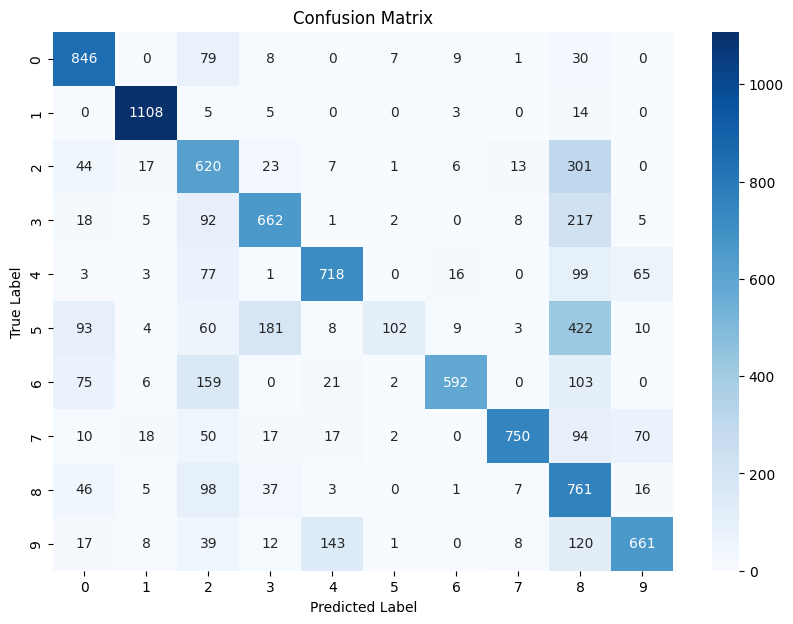

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.86      0.79       980
           1       0.94      0.98      0.96      1135
           2       0.48      0.60      0.54      1032
           3       0.70      0.66      0.68      1010
           4       0.78      0.73      0.76       982
           5       0.87      0.11      0.20       892
           6       0.93      0.62      0.74       958
           7       0.95      0.73      0.83      1028
           8       0.35      0.78      0.49       974
           9       0.80      0.66      0.72      1009

    accuracy                           0.68     10000
   macro avg       0.75      0.67      0.67     10000
weighted avg       0.76      0.68      0.68     10000



In [17]:
# Import necessary libraries for evaluation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the test data (accuracy)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Get predictions on the test data
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report for detailed metrics
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))


**5. Analysis:**

o Discuss the strengths and limitations of using an RBF network for this
dataset.

o How does the number of RBF units affect model performance?


**Strengths of using an RBF network for this dataset:**
- RBF networks can capture non-linear relationships between features (pixel values) and labels (character classes) more effectively than linear models.
- They are relatively simple to implement and understand compared to more complex deep learning models.
- They can be effective for smaller datasets with fewer training samples.

**Limitations of using an RBF network for this dataset:**
- Choosing the optimal number of RBF units and the centers can be challenging, requiring careful tuning.
- The performance can be sensitive to the choice of the Gaussian kernel's width (gamma).
- They may not scale as well as deep learning models for very large and complex datasets.

**How does the number of RBF units affect model performance?**
- Generally, increasing the number of RBF units can lead to improved accuracy and potentially better capturing complex patterns in the data.
- However, this can also increase the risk of overfitting, especially if the dataset is not large enough.
- A balance needs to be found to achieve good generalization performance.
- Experimenting with different values for the number of RBF units and observing the model's performance on the validation set can help determine the optimal choice.

**Further analysis can be performed by:**
- Varying the gamma value of the RBFs.
- Using different clustering techniques to determine the center values.
- Applying feature selection techniques to reduce the dimensionality of the input data.
